## Приоритизация гипотез.

В файле *hypothesis.csv* 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
###### Задача
* Применить фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Применить фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.

## Шаг №1. Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

Ознакомимся с датасетами и сделаем продобработку данных.

In [3]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

Посмотрим на типы даннных и проверим на пропуски

In [4]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Очевидно, что пропусков в hypothesis нет и все типы данных корректны. 

Теперь посмотрим на Датафрейм orders

In [6]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Здесь все корректно, переходим к visitors

In [14]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Здесь тоже все соответствует норме.

### Вывод: 

Мы познакомились с данными. Теперь можно начинать их предобработку.

## Шаг №2. Предобработка данных

Типы данных у orders корректен, однако, формат у даты поменяем позже. Посмотрим на наличие дублей и пропусков.

In [16]:
orders.isnull().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Пропусков нет и теперь проверим на дубли

In [17]:
orders.duplicated(subset=None).sum()

0

Дубли тоже отсутствуют. Переходим к visitors

Теперь посмотрим на дубли и нули

In [18]:
visitors.duplicated(subset=None).sum()

0

In [19]:
visitors.isnull().sum()

date        0
group       0
visitors    0
dtype: int64

Здесь опять все хорошо кроме даты, ее мы переформатируем далее в проекте.

Что касается столбца `hypothesis`, то здесь всего 9 строк, и каких-то проблем нет. Можно приступать к предобработке.

## Вывод: 
    
В ходе предобработки мы установили, что данные предоставленны качественные.  

## Шаг №3. Исследовательский анализ данных

Пропишем код, который позволит увеличить ширину ячейки

In [22]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [23]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Для дальнейшего удобства приведем названия столбцов к нижнему регистру

In [24]:
hypothesis.columns = hypothesis.columns.str.lower()

In [25]:
hypothesis['ICE'] =  (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).head(10)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


In [26]:
hypothesis['RICE'] =  (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False).head(10)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод: 

После того, как мы применили метод RICE для приоритезации гипотез, ситуация изменилась. Вместо 8, 0 и 7 Гипотезы вверху оказались 7, 2 и 0. Очевидно, что изменения произошли как раз из-за учета показателя охвата Reach, который не использовался в ICE. Получается, что именно гипотезы 7, 2, 0 затрагивают больше пользователей, а значит это самые существенные гипотезы с точки зрения бизнеса. 

## Шаг № 4. Анализ A/B-теста
Проанализируем A/B-тест

In [27]:
orders.columns = orders.columns.str.lower()
orders.head(10)


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [28]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Cоздадим массив уникальных пар значений дат и групп теста и зададим переменную

In [29]:
datesGroups = orders[['date','group']].drop_duplicates()

Теперь собираем агрегированные кумулятивные по дням данные о заказах

In [30]:
ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
)

Проделаем ту же процедуру для посетителей

In [31]:
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

Необходимо объядинить кумулятивные данные в одной таблице и присвоить ее столбцам понятные названия

In [32]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Посмотрим, что у нас получилось

In [33]:
cumulativeData.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


### Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

Создадим отдельные датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и B

In [34]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
cumulativeRevenueA['date'] = pd.to_datetime(cumulativeRevenueA['date'], format='%Y-%m-%d')
cumulativeRevenueB['date'] = pd.to_datetime(cumulativeRevenueB['date'], format='%Y-%m-%d')

Теперь построим два графика кумулятивной выручкидля группы A и B

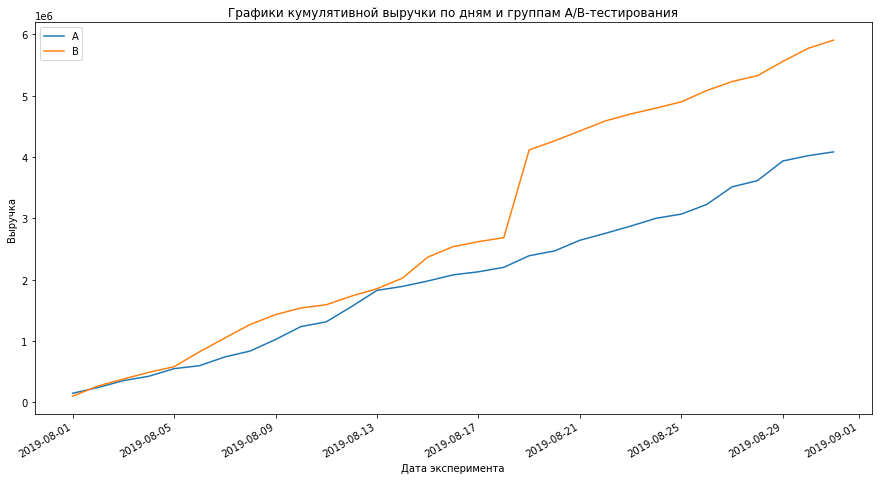

In [35]:
fig = plt.figure(figsize=[15,8])

plt.title("Графики кумулятивной выручки по дням и группам A/B-тестирования")
plt.xlabel('Дата эксперимента')
plt.ylabel('Выручка')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

fig.autofmt_xdate()
plt.legend()
plt.show();

### Вывод:

Как мы видим из графика, группа B приносила больше выручки, чем А. Есть определенный момент, когда вырочка у группы B шла резко вверх. Вероятно, что это могли быть выбросы в виде дорогих заказов. 

### Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

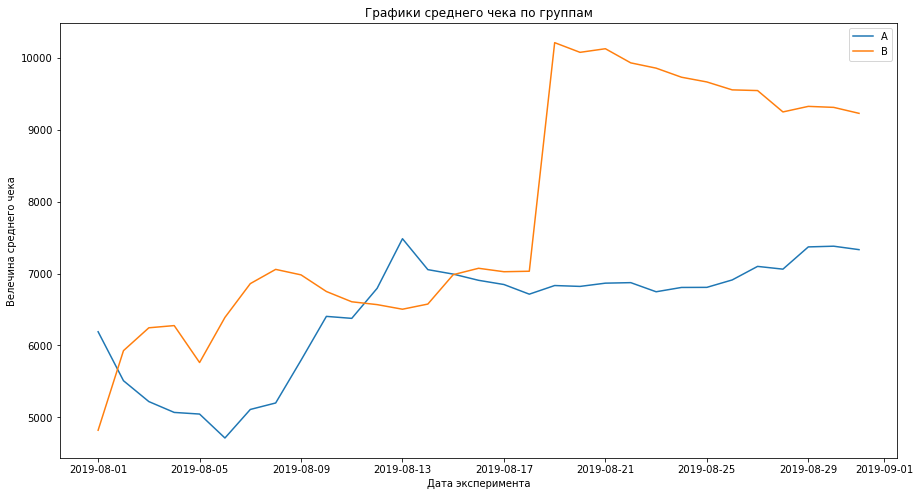

In [36]:
fig = plt.figure(figsize=[15,8])
plt.title('Графики среднего чека по группам')
plt.xlabel('Дата эксперимента')
plt.ylabel('Велечина среднего чека')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()

### Вывод:

Как мы и заметили на прошлом графике, группа B резко прибавляет после 17 Августа. Вероятно, была какая-то крупная закупка. Далее, группа А потихоньку увеличивает срадний чек, а B, наоборот, сбавляет.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

Все объединим в один датафрейм

In [37]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Теперь выведем сооношение среднего чека

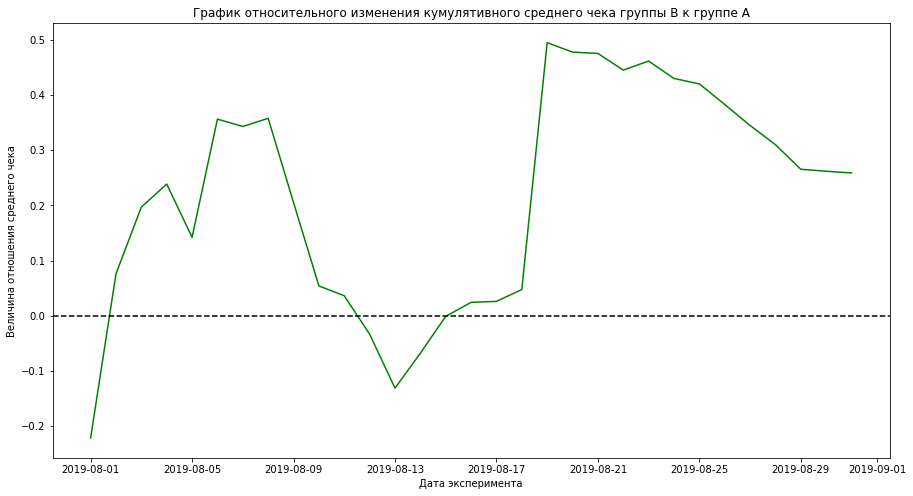

In [38]:
fig = plt.figure(figsize=[15,8])

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')

plt.xlabel('Дата эксперимента')
plt.ylabel('Величина отношения среднего чека')

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, color = 'green')

plt.axhline(y=0, color='black', linestyle='--')

plt.show()

### Вывод:
Становится очевидным, что есть области с сильным различием между сегментами. Это все говорит о том, что у нас точно есть выбросы. Вероятно, что какие-то крупные покупки на это влияют.

### Построим график кумулятивной конверсии по группам. Сделайте выводы и предположения.

Попытаемся вывсети график кумулятивной конверсии по такому же принципу, как и график выручки

In [39]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Теперь выделим отдельно группы A и B

In [40]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

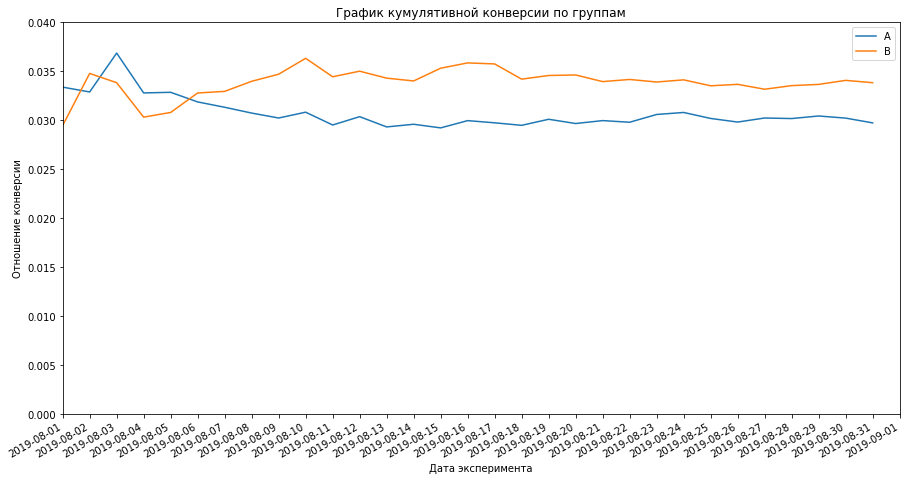

In [41]:
fig = plt.figure(figsize=[15,8])
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
fig.autofmt_xdate()
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата эксперимента')
plt.ylabel('Отношение конверсии')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0, 0.04])
plt.show()

### Вывод:

Как видно по графику, в певую неделю тестирования ситуация колеблится, и только потом группа B идет вверх, а вот показатели группы А падают. Ближе к концу конверсии начали падать в двух группах, возможно закончилась какая-нибудь акция.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

Объединим Датафреймы для построения графика

In [42]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

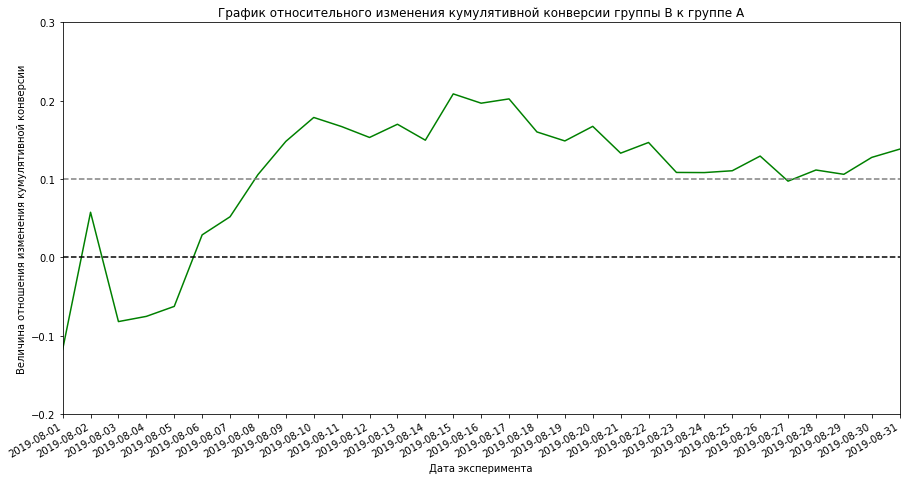

In [43]:
fig = plt.figure(figsize=[15,8])
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, color = 'green')
fig.autofmt_xdate()

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата эксперимента')
plt.ylabel('Величина отношения изменения кумулятивной конверсии')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3])

plt.show()



### Вывод:

Сперва кумулятивная конверсия группы B была ниже, чем у группы А. После первой недели B стала стремиться вверх и потом зафисировалась на одном уровне. Как мне кажется, действительно, надо посомтреть на выбросы.



## Построим точечный график количества заказов по пользователям. 

Для начала определим количество заказов по пользователям и отсортируем по убыванию.

In [44]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})

ordersByUsers.columns = ['visitorid','orders']

print(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

       visitorid  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Построим гистограмму распределения количества заказов

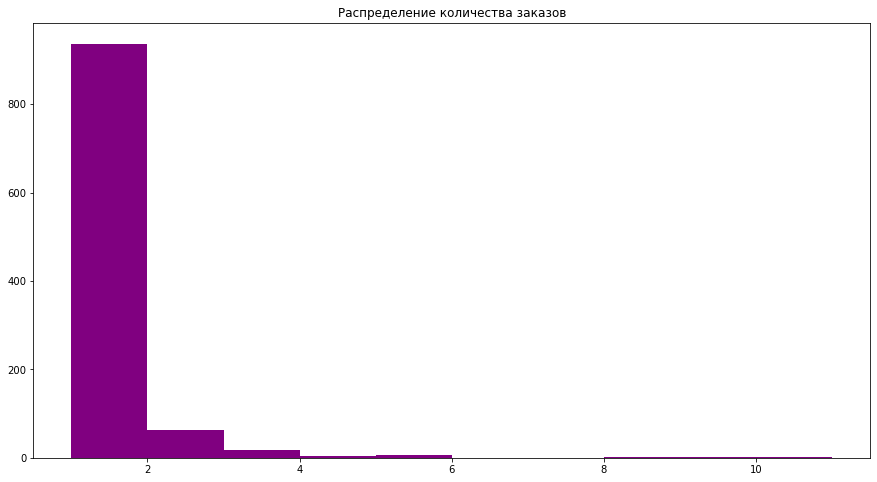

In [45]:
fig = plt.figure(figsize = (15,8))
plt.hist(ordersByUsers['orders'], bins = 10, color = 'purple')
plt.title('Распределение количества заказов')

plt.show()

Как мы видим, в основном все покупали по 1-2 раза, но встречаются юзеры,у которых было 5-6 и от 8 до 11. Логично, что более детальное распределение покажет точечная диаграма. 

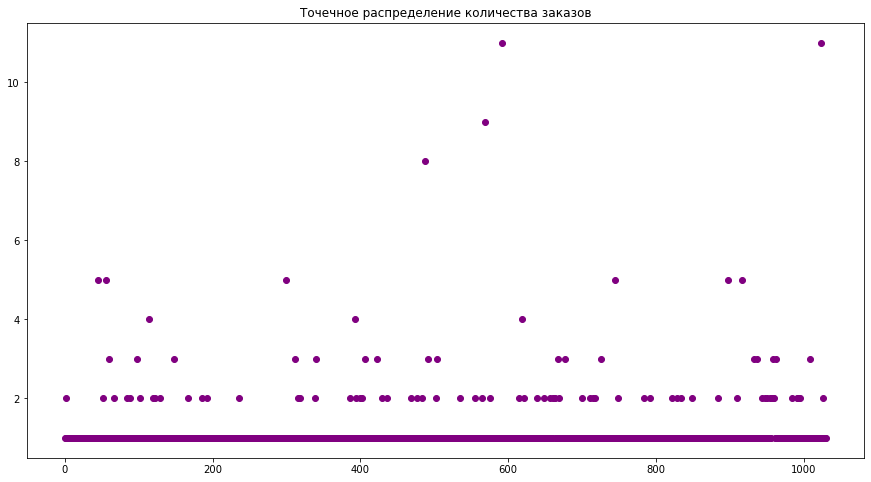

In [46]:
fig = plt.figure(figsize = (15,8))
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'], color = 'purple')
plt.title('Точечное распределение количества заказов')
plt.show()

### Вывод:

Вот здесь уже мы наглядно можем ознакомиться с выбросами. Как уже сказалось выше, в основном все покупают по 1-2 раза. Далее, для анализа попробуем определить перцентили.

## Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [47]:

print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


### Вывод: 

Получается, что больше двух заказов оформляли примерно 5% пользователей. Все что выше двух заказов будет логично отсеять

## Построим точечный график стоимости заказов.

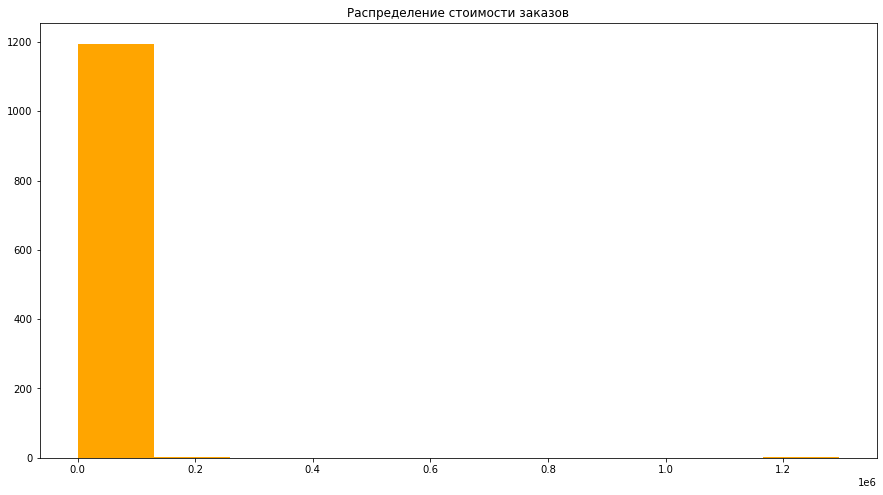

In [48]:
fig = plt.figure(figsize = (15,8))

plt.hist(orders['revenue'], bins = 10, color= 'orange')
plt.title('Распределение стоимости заказов')
plt.show()

### Вывод:

Здесь можно сделать вывод, что почти все были в пределах до 200000 тысяч. Необходимо определить границу выбросов более точечно.

## Построим точечный график стоимостей заказов

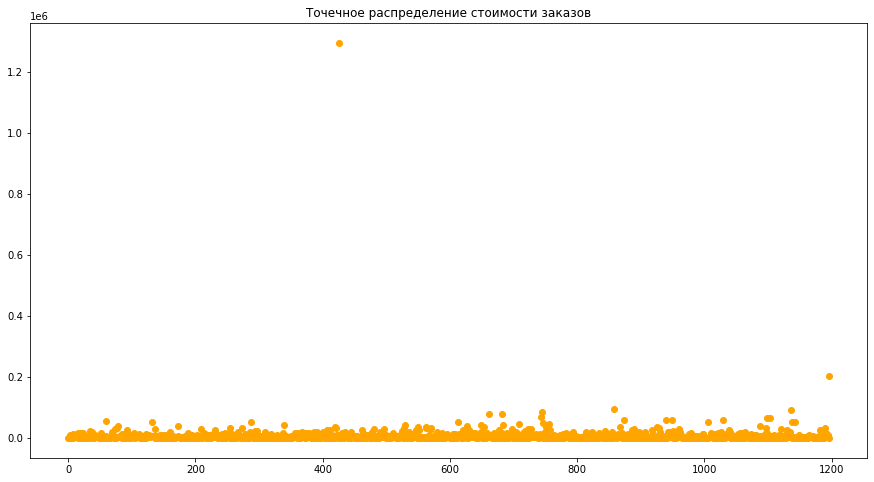

In [49]:
fig = plt.figure(figsize = (15,8))
x_values = pd.Series(range(0,len(orders)))

plt.scatter(x_values, orders['revenue'], color = 'orange')
plt.title('Точечное распределение стоимости заказов')
plt.show()

### Вывод: 

Вот здесь на графике уже наглядно видно, что почти все заказы были до 100000. Все что выше, логично будет считать выбросами, но посмотрим, что покажет перцентиль.

## Посчитаем 95-й и 99-й перцентили стоимости заказов

In [50]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


### Вывод: 

После расчета перцентилей, мы отсекаем все покупки , больше 28000

## Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [51]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACumulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACumulative.columns = ['date', 'visitorsCumulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCumulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCumulative.columns = ['date', 'visitorsCumulativeB']

Теперь посмотрим общее число заказов до выбранной даты включительно в двух группах

In [52]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACumulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACumulative.columns = ['date', 'ordersCumulativeA', 'revenueCumulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCumulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCumulative.columns = ['date', 'ordersCumulativeB', 'revenueCumulativeB']


Выведем таблицу с с общим числом заказов, выручкой в сутки, количество заказов.

In [53]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACumulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCumulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACumulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCumulative, left_on='date', right_on='date', how='left')


data.head(10)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCumulativeA,revenueCumulativeA,ordersCumulativeB,revenueCumulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCumulativeA,visitorsCumulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935
6,2019-08-07,18,142417,24,225334,145,740818,153,1049671,644,709,4629,4644
7,2019-08-08,16,96279,27,220918,161,837097,180,1270589,610,654,5239,5298
8,2019-08-09,16,188506,25,160812,177,1025603,205,1431401,617,610,5856,5908
9,2019-08-10,16,210495,23,107802,193,1236098,228,1539203,406,369,6262,6277


Теперь поделим датасеты на две группы

In [54]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

Зададим переменные sampleA и sampleB, где пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [55]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Покажем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. После этого округлим значения до трёх знаков после запятой.

* Задаем нулевую гипотезу H0 - о том, что статистически значимых различий в конверсии между группами нет.
* Задаем альтернативную гипотезу H1 - о том, что статистически значимые различия в конверсии между группами есть.

In [56]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.008
0.138


### Вывод: 

Значение P-value меньше 0.05. Получается, мы можем отвергнуть нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.

Стоит заметить, что относительный перевес в конверсиях группы B над А составляет 13.8%.

## Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Для рассчета статистически значимых различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() информаци о выручке с заказов, после чего определим относительные различия в среднем чеке между группами А и B.

* Задаем нулевую гипотезу H0 - о том, что в среднем чеке заказа между группами различий нет
* Задаем альтернативную гипотезу H1 - о том, что в среднем чеке заказа между группами есть различия.

In [57]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


### Вывод:
    
Значение P-value получилсоь больше 0.05. По этой причине мы не можем отвегнуть нулевую гипотезу и полагать, что в среднем чеке различия, нет. В итоге, средний чек группы B значительно почти на 26% выше среднего чека группы A.

## Посчитайем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Сперва определим аномальных пользователей, критерии для определения которых, мы вычислили ранее. Это будут пользователи, которые Заказывали от 3 раз и выше или совершили покупку стоимостью от 28000. 
Создадим срезы юзеров с числом заказов больше 2 — usersWithManyOrders и юзеров, покупавших от 28000 — usersWithExpensiveOrders. 

In [58]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print("Количество аномальных пользователей: {}".format(abnormalUsers.shape))

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
Количество аномальных пользователей: (74,)


В итоге, у нас вышло 74 пользователя, которых можно отбросить. 

Теперь определим, как их действия оказали влияение на результат. Получим количество заказов по группам.

In [59]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

Применим статистический критерий Манна-Уитни к полученным выборкам

* Задаем нулевую гипотезу H0 -  том, что статистически значимых различий в конверсии между группами нет.
* Задаем альтернативную гипотезу H1 -  о том, что статистически значимые различия есть в конверсии между группами.

In [60]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.007
0.173


### Вывод: 

Результат у нас получился примерно такой же, как и по сырым данным - p-value < 0.05. Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет можно отвергнуть.

Что касается конверсии, то группа B выше группы А на 17%.

## Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

* Задаем нулевую гипотезу H0 - о том, что в среднем чеке заказа между группами различий нет.
* Задаем альтернативную гипотезу H1 -   о том, что в среднем чеке заказа между группами есть различия.

In [61]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.369
-0.020


## Вывод:

Значение P-value почти ничем не отличается, а если говорить о разнице между группам, то она сильно изменилась. Теперь, средний чек группы B стал немного меньше группы А.

Мы можем сделать вывод, что аномалии серьезно повлияли на результат.

# Общий вывод по A/B тесту: 

* Есть статистически значимое различие по конверсии между группами как по сырым и чистым данным.
* По сырым и чистым данным нет статистически значимого различия по среднему чеку между группами.
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A.
* График различия среднего чека колеблется. Это говорит о том, что выводы по нему делать нельзя.

На мой взгляд, дальше нет смысла делать A/B тест, польскольку стало очевидным преймущество группы B.

### Очистим данные от выбросов и построим график кумулятивной выручки

In [62]:
pure_orders = orders[np.logical_not(orders['visitorid'].isin(abnormalUsers))].reset_index()

In [63]:
pure_orders.head(10)

,index,transactionid,visitorid,date,revenue,group
0,0,3667963787,3312258926,2019-08-15,1650,B
1,1,2804400009,3642806036,2019-08-15,730,B
2,2,2961555356,4069496402,2019-08-15,400,A
3,3,3797467345,1196621759,2019-08-15,9759,B
4,4,2282983706,2322279887,2019-08-15,2308,B
5,5,182168103,935554773,2019-08-15,2210,B
6,6,398296753,2900797465,2019-08-15,1860,B
7,7,2626614568,78758296,2019-08-15,1044,A
8,8,1576988021,295230930,2019-08-15,13710,A
9,9,1506739906,1882260405,2019-08-15,1855,B


In [64]:
datesGroups_new = pure_orders[['date','group']].drop_duplicates()

Отфильтруем таблицы и объявим переменные

In [65]:
ordersAggregated_new = (datesGroups
                    .apply(lambda x: pure_orders[np.logical_and(pure_orders['date'] <= x['date'], pure_orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
)                      
                       

In [66]:
visitorsAggregated_new = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

In [67]:
cumulativeData_new = ordersAggregated_new.merge(visitorsAggregated_new, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData_new.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Поделим датасеты на группы

In [68]:
cumulativeRevenueA_new = cumulativeData_new[cumulativeData_new['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB_new = cumulativeData_new[cumulativeData_new['group']=='B'][['date','revenue', 'orders']]
cumulativeRevenueA_new['date'] = pd.to_datetime(cumulativeRevenueA_new['date'], format='%Y-%m-%d')
cumulativeRevenueB_new['date'] = pd.to_datetime(cumulativeRevenueB_new['date'], format='%Y-%m-%d')

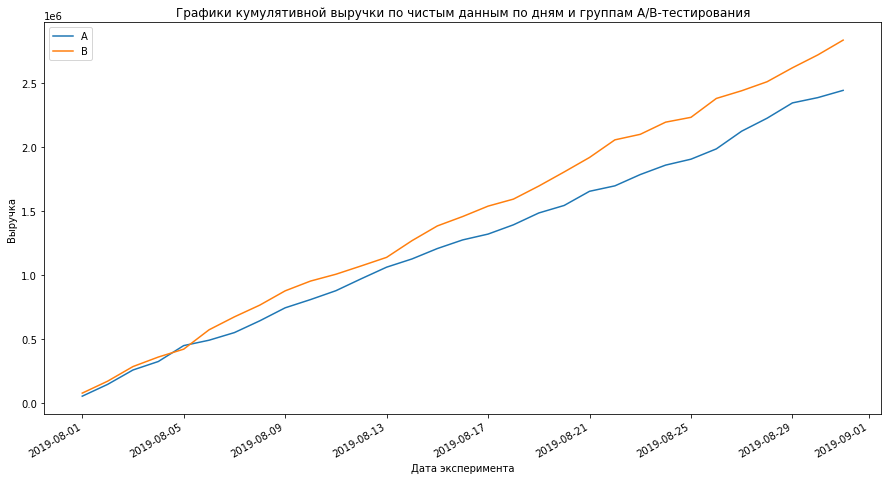

In [69]:
fig = plt.figure(figsize=[15,8])

plt.title("Графики кумулятивной выручки по чистым данным по дням и группам A/B-тестирования")
plt.xlabel('Дата эксперимента')
plt.ylabel('Выручка')

plt.plot(cumulativeRevenueA_new['date'], cumulativeRevenueA_new['revenue'], label='A')
plt.plot(cumulativeRevenueB_new['date'], cumulativeRevenueB_new['revenue'], label='B')

fig.autofmt_xdate()
plt.legend()
plt.show()

## Вывод:

По графику кумулятивной выручки чистых данных видно, что группа B приносила больше, и равномерно увеличивала разрыв с выручкой группы А